# Feature Selection and Model Cross-Validation

## Abstract

- The aim of this project is to propose a general framework for feature selection and figure out whether a higher number of model cross-validations might lead to its increased performance in terms of RMSE (root-mean-square error of predicted vs theoretical values), which is considered as a measure of predictive power and thus model performance.
- For these purposes we use the [Ames dataset](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt) on housing prices accompanied with a number of various characteristics, which might be useful in understanding the pricing criteria in general. Overall, these characteristics can be categorized into several groups: indoor specific (e.g., renovation, fireplaces), outdoor-specific (e.g., vicinities, infrastructure) and time-specific (e.g., year built). Thus, the dataset is abundant with various features and the task of a researcher is to figure out which ones might be of higher relevance. We create functions which make feature selection and compare the performance of cross-validated linear regression and k-nearest neighbors models, and also consider gradient descent model results in this respect.
- Features are selected based on their intuitive and statistical significance with respect to the target variable, while the problem of multicollinearity is adressed through corelation matrix. At the end of our analysis we conclude that higher number of cross-validations improves model performance and its predictive power, but the model variance also grows significantly (almost 8 fold over 100 iterations) and computational difficulties might also arise. Therefore, it is stated that a reasonable k number for cross-validations should be used instead of chasing as many of them as possible. As a rule of thumb, **10 is usually picked, and we show that it is exactly within first 10 cross-validations that the model improves the most**.

## Initial Data Preparation

There are three major types of variables in our dataset - numeric, ordinal and nominal. Before diving into their essence, we should clean our dataset from columns with many missing values, fill others with mean values, calculate houses' age at the time they were sold and drop columns, which are evidently unnecessary for further investigation. Among the latter we pick ids ("PID", "Order"), month sold (i.e., no intra-year seasonality is assumed), proximity to various city locations, data on roofs, type of heating, walls and foundation materials. We also created a dictionary to convert ordinal variables, represented as strings, to numbers using [dataset description table](https://s3.amazonaws.com/dq-content/307/data_description.txt) and then map it. Finally, we deleted the rows with evidently biased sale prices (i.e., not priced according to the market) - sales between family members and abnormal sales.

In [1]:
# import libraries needed for further analysis
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
sns.set_style("white")
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [2]:
# dowload raw data
data_raw = pd.read_table('https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt')

In [3]:
def transform_features(df):
    """ Delete columns with too many missing values, convert ordinal variables from 
        string to numerical representation, fill rows with averages for columns with 
        few missing values, calculate new variables related to house age, delete columns
        conveying little information related to pricing, plot dependent variable and 
        its logarithm
        Parameters: 
            df: raw dataset
        Return: cleaned dataset and target variable distribution plot
    """
    init_len = len(df)
    over_missing = df.isnull().sum()/len(df)
    over_missing = over_missing[over_missing>0.05]
    df = df.drop(over_missing.index, axis=1)
    ordinal_dict = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, 'Gtl': 1, 
                    'Mod': 2, 'Sev': 3, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, 'Av': 3, 'Mn': 2, 'No': 1, 
                    'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5,
                   'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1, 'Fin': 3, 'RFn': 2, 'Unf': 1, 'Y': 3, 'P': 2, 'N': 1, 'GdPrv': 4,
                   'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}
    for col in df.columns:
        df[col] = df[col].map(ordinal_dict).fillna(df[col])
    text_missing = df.select_dtypes(include=['object']).isnull().sum()
    text_missing = text_missing[text_missing>0]
    df = df.drop(text_missing.index, axis=1)
    df = df.fillna(df.mean())
    df['Yr Since Build'] = df['Yr Sold'] - df['Year Built']
    df['Yr Since Remod/Add'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df[(df['Yr Since Remod/Add']>0) | (df['Yr Since Build']>0)]
    df = df[(df['Sale Condition']!='Family') & (df['Sale Condition']!='Abnorml')]
    df = df.drop(["PID", "Order", "Mo Sold", "Year Built", "Year Remod/Add", 'Condition 1', 'Condition 2', 
                  'Roof Style', 'Roof Matl', 'Mas Vnr Area', 'Foundation', 'Heating'], axis=1)
    
    figure, axs = plt.subplots(1, 2, figsize=(15,5))
    figure.suptitle('Distribution Plots')
    ax1 = sns.distplot(df['SalePrice'], ax=axs[0]).set_title("Sale Price")
    ax2 = sns.distplot(np.log(df['SalePrice']), ax=axs[1]).set_title("Ln Sale Price")
    plt.show()
    
    final_len = len(df)
    print(round((init_len-final_len)/init_len*100), '% of the dataset was cleaned off with', final_len, 'rows remaining')
    return df

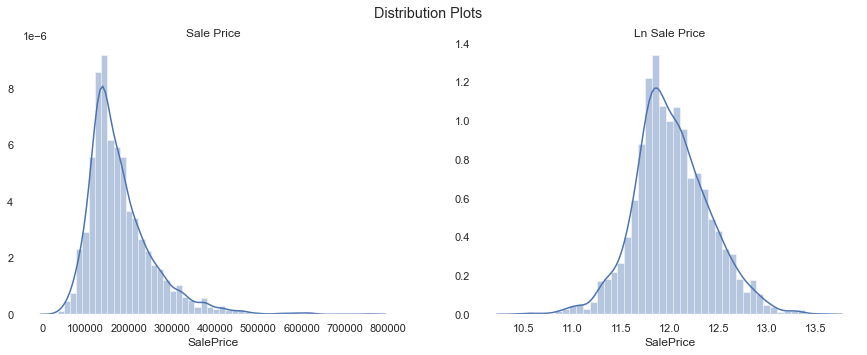

12 % of the dataset was cleaned off with 2580 rows remaining


In [4]:
# apply created function to dowloaded data
data = transform_features(data_raw)

Luckily, we have not lost much information from our dataset - only 12% of observations were deleted. In addition, the plot from above shows that the target variable, i.e., house sale prices, is skewed to the right with some large outliers. Therefore, consideration of log-transformed variable might be also informative.

## Feature selection

After the data-cleaning procedure let's dive into feature selection process. We consider numerical and ordinal variables together and choose only the ones with a strong enough relationship, but at the same time we get rid of the ones with a too high level of intercorrelation to deal with the potential multicollinearity issue. Thus, if two features are highly related to each other we delete one of them and keep another. Furthermore, we create a correlation matrix to get visual representation of features' relationships. Nominal features with too many distinct values are dropped in order to decrease possible noise, though they may carry relevant information (e.g., neighbourhoods and zoning might be important when buying a house - an ordinal variable for buyers' preferences is needed for such cases). The rest is dummified and the first value within each such feature is dropped thus becoming a reference for the rest in the same category. Corresponding heatmap is also created, though none of dummies is dropped afterwards.

In [5]:
def select_features(df, target, corr_lowest, corr_highest, unique_highest):
    """ Calculate correlations with the target variable, create correlation matrix 
    and heatmap for numerical, drop numerical and ordinal variables with too low correlations as 
    irrelevant, drop the ones with too high correlation to avoid multicollinearity, 
    drop nominal variables with missing values, dummify remaining nominal 
    variables while dropping the reference category and create their correlation heatmap
    Parameters:
        df: raw dataset
        target: dependent variable
        corr_lowest: lowest correlation to be considered in the model
        corr_highest: correlation threshold related to multicollinearity
        unique_highest: the highest amount of values within a separate category
    Return: dataset with selected features and heatmaps of features intercorrelations
    """
    corr = np.abs(df.corr()[target]).sort_values()
    strong_corr = corr[corr>corr_lowest]
    weak_corr = corr[corr<corr_lowest]
    corr_matrix_1 = df[strong_corr.index[:-1]].corr()
    figure, axs = plt.subplots(1, 2, figsize=(17,5))
    figure.suptitle('Correlation Heatmaps of Selected Features')
    ax1 = sns.heatmap(corr_matrix_1, ax=axs[0], cmap="Blues")
    axs[0].set_title('Numerical and ordinal variables')
    
    df = df.drop(weak_corr.index, axis=1)
    matrix = corr_matrix_1[(corr_matrix_1>corr_highest) & (corr_matrix_1!=1)]
    intercorr = matrix.notna().sum()[matrix.notna().sum()>0]
    df = df.drop(intercorr[:int(len(intercorr)/2)].index, axis=1)
    
    categorical = df.select_dtypes(include=['object']).columns
    df[categorical] = df[categorical].apply(lambda col: col.astype('category'))
    uniqueness_counts = df[categorical].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > unique_highest].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']), drop_first=True)], 
                     axis=1).drop(df.select_dtypes(include=['category']).columns, axis=1)
    
    dummies = pd.concat([df.select_dtypes(include=['uint8']), df[target]], axis=1)
    corr = np.abs(dummies.corr()[target]).sort_values()
    corr_matrix_2 = df[corr.index[:-1]].corr()
    ax2 = sns.heatmap(corr_matrix_2, ax=axs[1], cmap="Blues")
    axs[1].set_title('Nominal variables')
    plt.show()
    
    return df

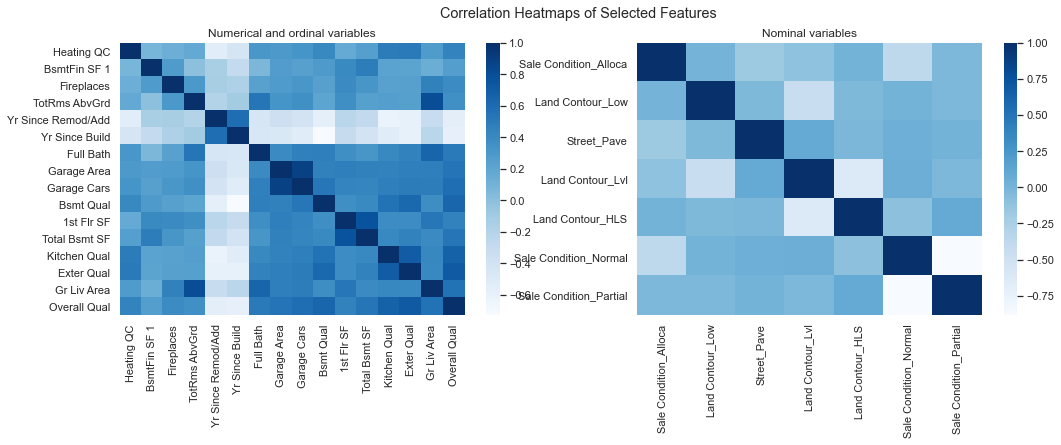

In [6]:
# apply created function to cleaned data
data_selected = select_features(data, 'SalePrice', 0.4, 0.8, 4)

Some of features are skewed to the right thus having some outliers, as shown in the descriptive statistics below.

In [7]:
# description of chosen features
data_selected.describe()

,Overall Qual,Exter Qual,Bsmt Qual,BsmtFin SF 1,Total Bsmt SF,Heating QC,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,Fireplaces,Garage Cars,SalePrice,Yr Since Build,Yr Since Remod/Add,Street_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Sale Condition_Alloca,Sale Condition_Normal,Sale Condition_Partial
count,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.00000
mean,6.074806,3.384496,3.567534,440.391860,1039.251163,4.149612,1149.974806,1490.313566,1.560465,3.492636,0.608527,1.761925,179988.612403,36.877907,23.575581,0.995349,0.040310,0.020543,0.900775,0.009302,0.934496,0.05155
std,1.366605,0.565445,0.677828,429.878992,420.413541,0.955028,373.985335,485.129431,0.550500,0.647380,0.647904,0.744586,76195.209409,29.905749,20.487394,0.068054,0.196724,0.141875,0.299022,0.096018,0.247461,0.22116
min,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,334.000000,334.000000,0.000000,1.000000,0.000000,0.000000,35000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,5.000000,3.000000,3.000000,0.000000,789.000000,3.000000,874.000000,1118.750000,1.000000,3.000000,0.000000,1.000000,130000.000000,8.000000,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000
50%,6.000000,3.000000,4.000000,378.000000,984.000000,5.000000,1078.000000,1440.000000,2.000000,3.000000,1.000000,2.000000,160225.000000,35.000000,15.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000
75%,7.000000,4.000000,4.000000,732.000000,1286.500000,5.000000,1374.250000,1734.500000,2.000000,4.000000,1.000000,2.000000,212750.000000,54.000000,42.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000
max,10.000000,5.000000,5.000000,2288.000000,3206.000000,5.000000,3820.000000,4316.000000,4.000000,5.000000,4.000000,5.000000,755000.000000,136.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Cross-Validation of Linear Regression and K-Neighbors Models

Now that we have our dataset prepared for the analysis we can check how RMSE changes with the number of cross-validations being increased, as well as its variance within each iteration. Moreover, we can also compare linear regression and k-neighbors models performance at each iteration and compute optimal number of neighbours, which is usually considered to be 4. Overall, our estimation approach (i.e., empirical strategy) is known as hedonic pricing method, when the monetary value of a good is constructed/estimated based on its characteristics. It is also important to note that we estimate total price and not the price per square meter, which is usually referred to when talking about property prices, and the corresponding living area of properties is thus included into estimation.

In [8]:
def train_and_test(df, target, iterations):
    """ Calculate RMSE and their variance while increasing the number of cross-validations to see whether
    it is an effective technique for improving model performance. Linear regression and k-nearest neighbors 
    models are considered. Optimal number of k-neighbors is also calculated for each iteration (i.e., cross-
    validation)
    Parameters:
        df: dataset with selected features
        target: dependent variable
        iterations: maximum number of cross-validations
    Return: graphical representation of calculated RMSE and its variance
    """
    features = df.columns.drop(target)
    df[features] = (df[features] - np.min(df[features]))/(np.max(df[features]) - np.min(df[features]))
    df['Intercept'] = 1
    lr = linear_model.LinearRegression()
    rmse_values_lr = []
    rmse_values_knn = [np.NaN]
    k_knn = [np.NaN]
    std_lr = [np.NaN, np.NaN]
    std_knn = [np.NaN, np.NaN]
    k_numbers = []
    for k in range(iterations):
    
        if k == 0:  
            train = df[:int(len(df)/2)]
            test = df[int(len(df)/2):]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            rmse = np.sqrt(mean_squared_error(test[target], predictions))
            rmse_values_lr.append(rmse)
            k_numbers.append(k)
            
        if k == 1:
            shuffled_df = df.sample(frac=1)
            train = shuffled_df[:int(len(df)/2)]
            test = shuffled_df[int(len(df)/2):]
            
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            rmse_1 = np.sqrt(mean_squared_error(test[target], predictions))
            
            lr.fit(test[features], test[target])
            predictions = lr.predict(train[features])
            rmse_2 = np.sqrt(mean_squared_error(train[target], predictions))
            
            rmse = np.mean([rmse_1, rmse_2])                                                  
            rmse_values_lr.append(rmse)
            k_numbers.append(k)
            
            best_rmse_knn_1 = []
            best_rmse_knn_2 = []
            
            # run through 20 neighbours at each iteration
            for i in range(1, 20):
                knn = KNeighborsRegressor(n_neighbors=i)
                knn.fit(train[features], train[target])
                predictions = knn.predict(test[features])
                rmse = np.sqrt(mean_squared_error(test[target], predictions))
                best_rmse_knn_1.append(rmse)
                
                knn = KNeighborsRegressor(n_neighbors=i)
                knn.fit(test[features], test[target])
                predictions = knn.predict(train[features])
                rmse = np.sqrt(mean_squared_error(train[target], predictions))
                best_rmse_knn_2.append(rmse)
                
            best_rmse_knn = np.mean([min(best_rmse_knn_1), min(best_rmse_knn_2)])
            rmse_values_knn.append(best_rmse_knn)
            best_k_knn = round(np.mean([best_rmse_knn_1.index(min(best_rmse_knn_1)), best_rmse_knn_2.index(min(best_rmse_knn_2))]))
            k_knn.append(best_k_knn)
            
        if k > 1:
            kf = KFold(n_splits=k, shuffle=True)
            rmses_lr = []
            rmses_knn = []
            for train_index, test_index, in kf.split(df):
                train = df.iloc[train_index]
                test = df.iloc[test_index]
                lr.fit(train[features], train[target])
                predictions = lr.predict(test[features])
                rmse = np.sqrt(mean_squared_error(test[target], predictions))
                rmses_lr.append(rmse)
                best_rmse_knn = []
                best_k_knn = []
                
                # run through 20 neighbours at each iteration
                for i in range(1, 20):
                    knn = KNeighborsRegressor(n_neighbors=i)
                    knn.fit(train[features], train[target])
                    predictions = knn.predict(test[features])
                    rmse = np.sqrt(mean_squared_error(test[target], predictions))
                    best_rmse_knn.append(rmse)
                    
                rmses_knn.append(min(best_rmse_knn))
                best_k_knn.append(best_rmse_knn.index(min(best_rmse_knn))+1)
            
            rmse = sum(rmses_lr)/len(rmses_lr)
            rmse_values_lr.append(rmse)
            std_lr.append(np.nanstd(rmses_lr))
            rmse = sum(rmses_knn)/len(rmses_knn)
            rmse_values_knn.append(rmse)
            std_knn.append(np.nanstd(rmses_knn))
            k_knn.append(round(np.mean(best_k_knn)))
            k_numbers.append(k)
    
    figure, axs = plt.subplots(1, 2, figsize=(15,5))
    figure.suptitle('RMSE Values Comparison')
    ax1 = sns.lineplot(k_numbers, rmse_values_lr, ax=axs[0])
    ax2 = sns.lineplot(k_numbers, rmse_values_knn, ax=axs[1])
    axs[0].set_title('Linear Regression')
    axs[0].set_xlabel('Cross-Validation Iterations')
    axs[0].set_ylabel('RMSE')
    axs[1].set_title('K-Nearest Neighbour')
    axs[1].set_xlabel('Cross-Validation Iterations')
    axs[1].set_ylabel('RMSE')
    
    figure, axs = plt.subplots(1, 2, figsize=(15,5))
    figure.suptitle('Model Variance Comparison')
    ax1 = sns.lineplot(k_numbers, std_lr, ax=axs[0])
    ax2 = sns.lineplot(k_numbers, std_knn, ax=axs[1])
    axs[0].set_title('Linear Regression')
    axs[0].set_xlabel('Cross-Validation Iterations')
    axs[0].set_ylabel('Standard Deviation')
    axs[1].set_title('K-Nearest Neighbour')
    axs[1].set_xlabel('Cross-Validation Iterations')
    axs[1].set_ylabel('Standard Deviation')
    plt.show()
    
    output = print('The best RMSE value of', round(np.nanmin(rmse_values_knn), 2), 'is observed at', 
                 k_numbers[rmse_values_knn.index(np.nanmin(rmse_values_knn))], 'cross-validations and', 
                 k_knn[rmse_values_knn.index(np.nanmin(rmse_values_knn))], 'neighbors for k-nearest neighbors model and', 
                 round(np.nanmin(rmse_values_lr), 2), 'is observed at', k_numbers[rmse_values_lr.index(np.nanmin(rmse_values_lr))], 
                 'cross-validations for linear regression model')
       
    return output

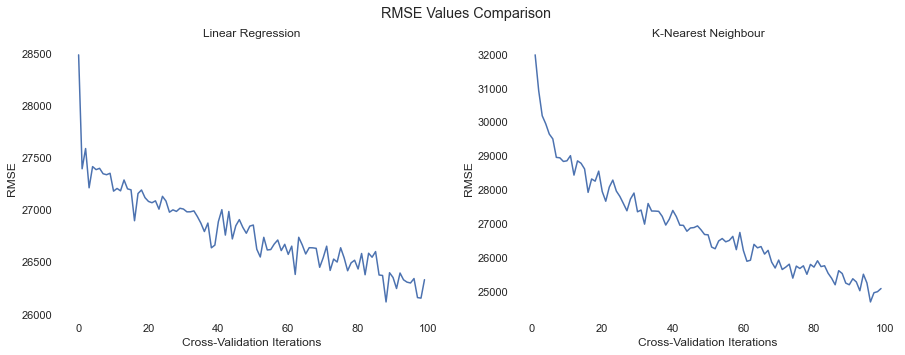

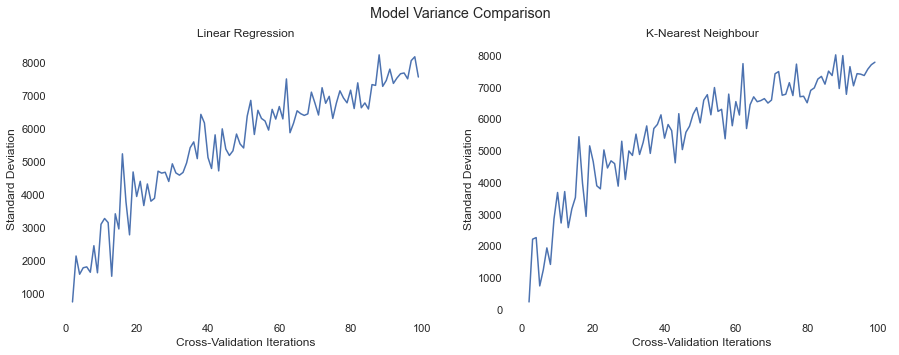

The best RMSE value of 24674.24 is observed at 96 cross-validations and 12 neighbors for k-nearest neighbors model and 26114.13 is observed at 88 cross-validations for linear regression model


In [9]:
# Apply created function to selected features
train_and_test(data_selected, 'SalePrice', 100)

The results turn out to be quite intriguing - initially linear regression model performes much better in terms of RMSE, but with the increasing number of cross-validations k-nearest neigbours model actually catches up (at around 60 cross-validations) and performs even better afterwards, thus having faster improvements over iterations. This might be explained by proposition that our model doesn't contain much noise, since we have utilised strict correlation threshold for feature selection and haven't introduced many dummy variables. In addition, **very steep performance improvement takes place within first ten cross-validations for both models**. Standard deviations of RMSEs at ech cross-validation level are similar for linear regression and k-nearest neighbour model both in magnitude and **gradual upward dynamics**. It is also noteworthy that the optimal number of k-neighbours varies between 2 and 6, being most often 4, which is consistent with the general consus on its optimal number. However, from time to time this figure might also be even higher than 10.

## Cross-Validation of Gradient Descent Model

As the further step in our analysis let's also investigate gradient descent model performance over changing number of cross-validations. Due to computational complexity (we iterate 500 times for each cross-validation, which is usually still not enough for this model) we only consider results up to 25 cross-validations.

In [10]:
def gradientDescent(X, y, learning_rate, iterations):
    """ Calculate coefficients through iterations using gradient descent model.
    Initial coefficients of each feature are all set to 0 at the start.
    Parameters:
        X: set of independent variables
        y: dependent variable
        learning_rate: gradient descent learning rate
        iterations: number of iterations for model training
    Return: coefficients from the last iteration
    """
    coef = np.array([0]*len(X.columns))
    
    for i in range(iterations):        
        y1 = coef*X
        y1 = np.sum(y1, axis=1)
        
        for c in range(len(X.columns)):
            coef[c] = coef[c] - learning_rate*(sum((y1-y)*X.iloc[:,c])/len(X))
            
        if i == iterations-1:
            return coef

In [11]:
def gradientDescent_crossValidation(df, target, iterations):
    """ Calculate RMSE and their variance while increasing the number of cross-validations to see whether
    it is an effective technique for improving model performance. Gradient descent model is considered. 
    Parameters:
        df: dataset with selected features
        target: dependent variable
        iterations: maximum number of cross-validations
    Return: graphical representation of calculated RMSE and its variance
    """
    features = df.columns.drop(target)
    df[features] = (df[features] - np.min(df[features]))/(np.max(df[features]) - np.min(df[features]))
    df['Intercept'] = 1
    train = df[:int(len(data)/2)]
    test = df[int(len(data)/2):]
    rmse_gd_values = []
    std_gd = [np.NaN, np.NaN]
    k_numbers = []
    
    for k in range(iterations):
        
        if k == 0:
            y1 = gradientDescent(train[features], train[target], 0.01, 500)*test[features]
            y1 = np.sum(y1, axis=1)
            rmse = sum(np.sqrt((y1-test[target])**2))/(len(test[target]))
            rmse_gd_values.append(rmse)
            k_numbers.append(k)
            
        if k == 1:
            shuffled_df = df.sample(frac=1)
            train = shuffled_df[:int(len(df)/2)]
            test = shuffled_df[int(len(df)/2):]
            dataframes = [[train, test], [test, train]]
            rmses = []
            
            for i in dataframes:
                y1 = gradientDescent(i[0][features], i[0][target], 0.01, 500)*i[1][features]
                y1 = np.sum(y1, axis=1)
                rmse = sum(np.sqrt((y1-i[1][target])**2))/(len(test[target]))
                rmses.append(rmse)
            rmse_gd_values.append(np.mean(rmses))
            k_numbers.append(k)
            
        if k > 1:
            kf = KFold(n_splits=k, shuffle=True)
            rmses = []
            
            for train_index, test_index, in kf.split(df):
                train = df.iloc[train_index]
                test = df.iloc[test_index]
                y1 = gradientDescent(train[features], train[target], 0.01, 500)*test[features]
                y1 = np.sum(y1, axis=1)
                rmse = sum(np.sqrt((y1-test[target])**2))/(len(test[target]))
                rmses.append(rmse)
                
            rmse = sum(rmses)/len(rmses)
            rmse_gd_values.append(rmse)
            std_gd.append(np.std(rmses))
            k_numbers.append(k)
    
    figure, axs = plt.subplots(1, 2, figsize=(15,5))
    figure.suptitle('RMSE and Model Variance Dynamics')
    ax1 = sns.lineplot(k_numbers, rmse_gd_values, ax=axs[0])
    ax2 = sns.lineplot(k_numbers, std_gd, ax=axs[1])
    axs[0].set_title('RMSE')
    axs[0].set_xlabel('Cross-Validation Iterations')
    axs[0].set_ylabel('RMSE')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Cross-Validation Iterations')
    axs[1].set_ylabel('Standard Deviation')
    plt.show()
    
    output = print('The best RMSE value of', round(np.nanmin(rmse_gd_values), 2), 'is observed at', 
                 k_numbers[rmse_gd_values.index(np.nanmin(rmse_gd_values))], 'cross-validations for gradient descent model')
    
    return output

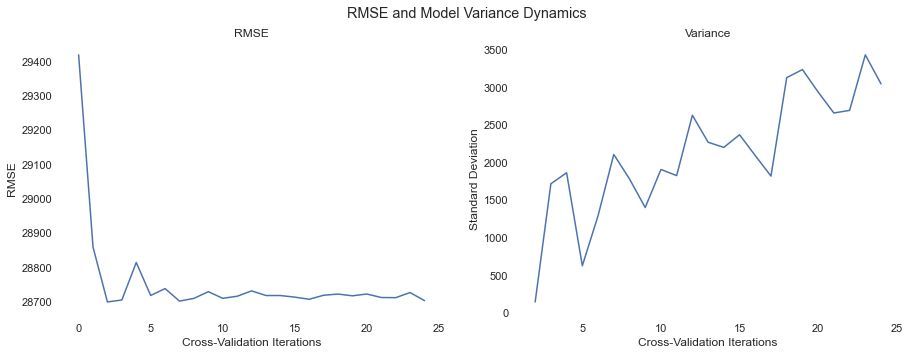

The best RMSE value of 28698.29 is observed at 2 cross-validations for gradient descent model


In [12]:
# Apply created function to selected features
gradientDescent_crossValidation(data_selected, 'SalePrice', 25)

After significant improvements at the initial several cross-validations, gradient descent model performance in terms of RMSE stagnates, meaning that further cross-validations do not improve it much - the lowest RMSE value is observed at the level of 2 cross-validations. RMSE standard deviation at each cross-validation increases, being quite similar to that of the previous models.

## Cross-Validation with Log-Transformed Target Variable

As an additional point in our analysis let's check the performance of two inital models with log-transformed target (originally somewhat skewed to the right) and compare them.

Results for log-transformed dependent variable


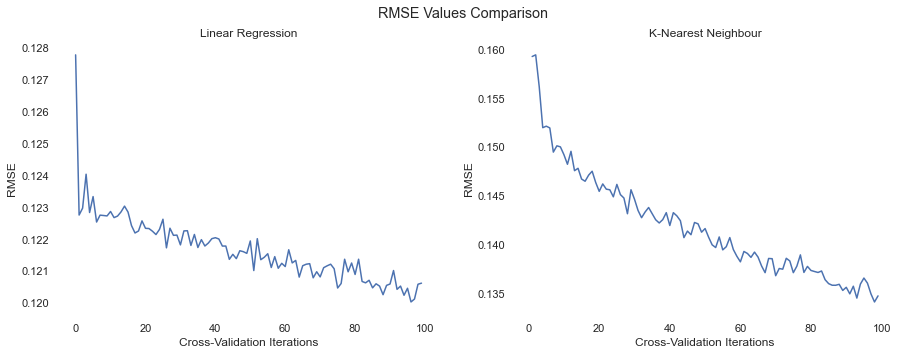

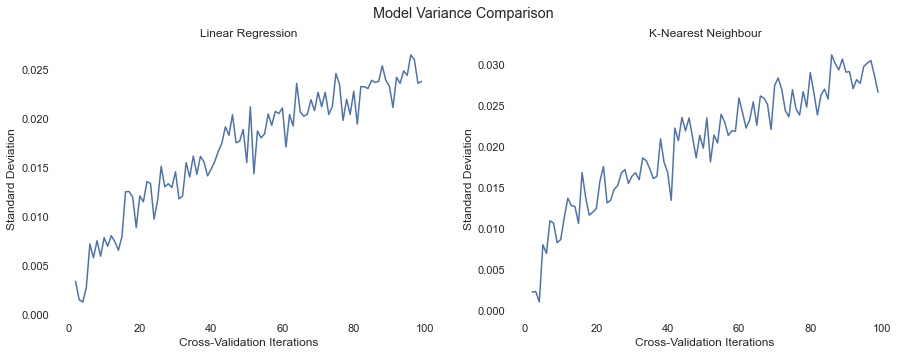

The best RMSE value of 0.13 is observed at 98 cross-validations and 3 neighbors for k-nearest neighbors model and 0.12 is observed at 96 cross-validations for linear regression model


In [13]:
# Transform target variable by applying logarithm and run cross-validation for two baseline models
data_ln = data_selected
data_ln['SalePrice'] = np.log(data_ln['SalePrice'])
print('Results for log-transformed dependent variable')
train_and_test(data_ln, 'SalePrice', 100)

After log-transformation of dependent variable linear regression model performs better even at the level of 100 cross-validations and has much lower standard deviation of RMSE values. Therefore, it might be supposed that the lower the skeweness of the target, the higher the level of cross-validations needed for k-nearest neighbours model to outperform linear regression model. However, such hypothesis needs further empirical checks to confirm of refute it, which is out of the scope of the given analysis.

## OLS Regression Results and Features' Significance in Property Pricing

Finally, let's consider statistical significance and magnitude of each feature in our model, which contributes to property sale price, as well as their overall explanatory power through running OLS regression on standardized data, plot the results and check residuals distribution.

In [14]:
# Run OLS regression to check for statistical significance of features considered in previous analysis
import statsmodels.api as sm
x = data_selected.drop('SalePrice', axis=1).values.reshape(-1, len(data_selected.columns[1:]))
x = (x - x.mean())/x.std() # standardize dependent variables for getting comparable coefs to understand their magnitude
y = np.log(data_selected['SalePrice']).values.reshape(-1, 1)

results = sm.OLS(y, x).fit()
print(results.summary(yname='Ln Sale Price', xname=list(data_selected.drop('SalePrice', axis=1).columns)))

                            OLS Regression Results                            
Dep. Variable:          Ln Sale Price   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1050.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:11:19   Log-Likelihood:                 8143.5
No. Observations:                2580   AIC:                        -1.624e+04
Df Residuals:                    2558   BIC:                        -1.611e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Overall Qual               0

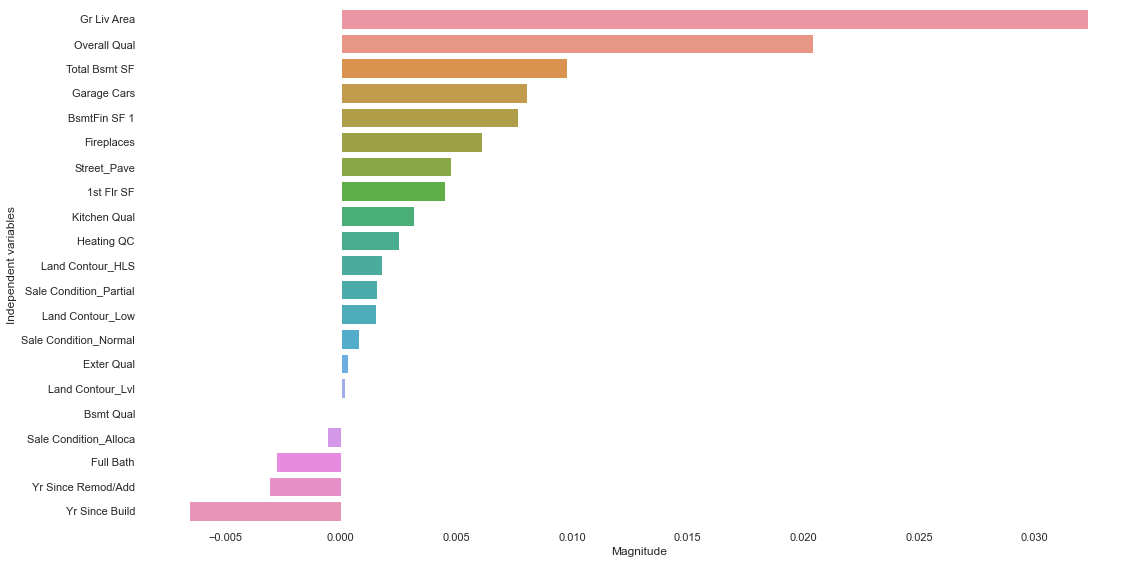

In [15]:
# Plot magnitudes of features in their relation to sale price
coef = pd.DataFrame(results.params[:-1]).rename(columns = {0:'Magnitude'})
coef['Independent variables'] = data_selected.drop('SalePrice', axis=1).columns[:-1]
sns.catplot(x='Magnitude', y='Independent variables', data=coef.sort_values(by='Magnitude', ascending=False), kind='bar', height=8, aspect=2)
plt.show()

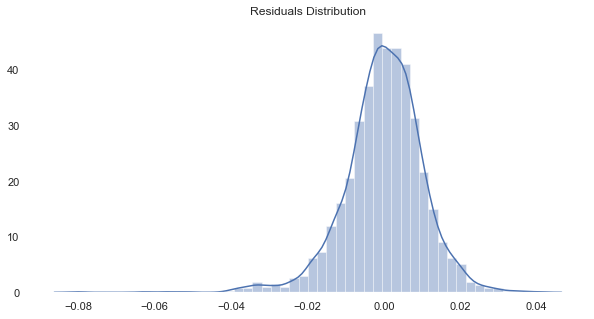

In [16]:
plt.figure(figsize=(10,5))
sns.distplot(results.resid).set_title('Residuals Distribution')
plt.show()

Overall, almost 90% of variation in sale prices is explained by our model with 21 regressors, meaning that they capture most of the information needed to understand property prices. The most important characteristics creating properties' monetary value are living area, overall material quality of house, number of fireplaces, paved roads (might be considered as a proxy for neighbourhood quality to some extent) as compared to gravel ones, kitchen quality (quite compatible with the saying "kitchen sells the house"), heating quality. On the other hand, house total age and the time since the last remodeling are the major negative contributors to the property price.

However, some of the regressors turn out to be statistically insignificant and have very low coefficients (i.e., magnitudes). It seems possible to assume that much of their explanatory power is taken by other similar variables - e.g., the variable depicting overall quality of the house makes external and basement quality insignificant both statisitcally and in terms of magnitude. Another insignificant variables are those related to sales conditions, meaning that the way house has been sold is not reflected in its price. Land flatness also doesn't seem to be important, though some of the categories within this variable are statistically significant.

## Conclusion

Throughout the project we selected features based on their intuitive and statistical significance - the latter on the basis of individual Pearson correlation coefficients. We have also shown how correlation heatmaps may come in handy for feature selection. We have tried to keep the number of nominal variables low, since dummification of categories with many distinct values may bring much noise into the model, while some of them might be similarly correlated to the target causing multicollinearity issue.

Our analysis has shown that the more cross-validations we make, the better model performance. However, it is easily explained by the fact that the more we partition dataset, the smaller the test set we use to validate estimation results, which is *per se* leading to smaller variance of target variable, *ceteris paribus*. At the same time, variance of RMSEs grows significantly - almost 8-fold over 100 iterations of cross-validations. Therefore, one should not be tempted to partition data too much and has better to use a reasonable k number.

The common convention states that the optimal number of cross-validations should be around 10, since at higher iterations test dataset becomes smaller, while variance of obtained RMSEs higher. It is also too much computationally intensive to partition datasets (especially large ones) into many small parts and cross-validate estimates. At the end of the day the best model is the one with the optimal ratio between bias (depends on the relevant features chosen) and variance (depends on the number of features chosen). Usually such a "sweet spot" might be found only empirically for each model on individual basis and there is no "one size fits all" solution. 